# Time series Cadu e JP


In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("Dataset 1_EV charging reports.csv", sep=';')
df.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


### ========================= Data Preparation =========================

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_ID         6878 non-null   int64  
 1   Garage_ID          6878 non-null   object 
 2   User_ID            6878 non-null   object 
 3   User_type          6878 non-null   object 
 4   Shared_ID          1412 non-null   object 
 5   Start_plugin       6878 non-null   object 
 6   Start_plugin_hour  6878 non-null   int64  
 7   End_plugout        6844 non-null   object 
 8   End_plugout_hour   6844 non-null   float64
 9   El_kWh             6878 non-null   object 
 10  Duration_hours     6844 non-null   object 
 11  month_plugin       6878 non-null   object 
 12  weekdays_plugin    6878 non-null   object 
 13  Plugin_category    6878 non-null   object 
 14  Duration_category  6844 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 806.1+ KB


In [4]:
#Null Values
print(f"df shape: {df.shape}")
df.isnull().sum()

df shape: (6878, 15)


session_ID              0
Garage_ID               0
User_ID                 0
User_type               0
Shared_ID            5466
Start_plugin            0
Start_plugin_hour       0
End_plugout            34
End_plugout_hour       34
El_kWh                  0
Duration_hours         34
month_plugin            0
weekdays_plugin         0
Plugin_category         0
Duration_category      34
dtype: int64

In [5]:
#A big quantity of null values --> drop
df.drop(['Shared_ID'], axis=1, inplace=True)
df.isnull().sum()

session_ID            0
Garage_ID             0
User_ID               0
User_type             0
Start_plugin          0
Start_plugin_hour     0
End_plugout          34
End_plugout_hour     34
El_kWh                0
Duration_hours       34
month_plugin          0
weekdays_plugin       0
Plugin_category       0
Duration_category    34
dtype: int64

In [6]:
#the following columns will not be useful to us: session_ID, Duration_category, Plugin_category, weekdays_plugin, 
#                                                month_plugin, User_type

no_useful = ["session_ID", "Duration_category", "Plugin_category", "weekdays_plugin", "month_plugin", "User_type"]
df.drop(no_useful, axis=1, inplace=True)
display(df.head())
df.info()

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours
0,AdO3,AdO3-4,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05"
1,AdO3,AdO3-4,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667"
2,AdO3,AdO3-4,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889"
3,AdO3,AdO3-2,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222"
4,AdO3,AdO3-2,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Garage_ID          6878 non-null   object 
 1   User_ID            6878 non-null   object 
 2   Start_plugin       6878 non-null   object 
 3   Start_plugin_hour  6878 non-null   int64  
 4   End_plugout        6844 non-null   object 
 5   End_plugout_hour   6844 non-null   float64
 6   El_kWh             6878 non-null   object 
 7   Duration_hours     6844 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 430.0+ KB


In [7]:
#El_kWh: object --> float
#Duration_hours: objetc --> float
#Start_plugin and End_plugout: object --> datetime

df["El_kWh"] = df['El_kWh'].str.replace(',', '.').astype(float)

df["Duration_hours"] = df['Duration_hours'].str.replace(',', '.').astype(float)

df['Start_plugin'] = df['Start_plugin'].str.split(' ').str[0]
df["Start_plugin"] = pd.to_datetime(df["Start_plugin"])
# df["Start_plugin"] = df["Start_plugin"].dt.strftime('%d/%m/%Y')
# df["Start_plugin"] = pd.to_datetime(df["Start_plugin"], format='%d/%m/%Y')


df['End_plugout'] = df['End_plugout'].str.split(' ').str[0]
df["End_plugout"] = pd.to_datetime(df["End_plugout"])
# df["End_plugout"] = df["End_plugout"].dt.strftime('%d/%m/%Y')
# df["End_plugout"] = pd.to_datetime(df["End_plugout"], format='%d/%m/%Y')

display(df.head())
df.info()

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours
0,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.30,0.050000
1,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.87,0.136667
2,AdO3,AdO3-4,2018-12-21,11,2018-12-21,19.0,29.87,8.216389
3,AdO3,AdO3-2,2018-12-22,16,2018-12-23,16.0,15.56,24.419722
4,AdO3,AdO3-2,2018-12-24,22,2018-12-24,23.0,3.62,0.970556


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Garage_ID          6878 non-null   object        
 1   User_ID            6878 non-null   object        
 2   Start_plugin       6878 non-null   datetime64[ns]
 3   Start_plugin_hour  6878 non-null   int64         
 4   End_plugout        6844 non-null   datetime64[ns]
 5   End_plugout_hour   6844 non-null   float64       
 6   El_kWh             6878 non-null   float64       
 7   Duration_hours     6844 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 430.0+ KB


In [8]:
#Creating a new column that is also going to be predicted
#The dataset is from Norway, so we search about the cost of 1khw there and we r using the found values (in R$) to create the new feature
#The source link is below  

random_number = round(random.uniform(1, 1.4),2) 
#The cost of 1kwh in Norway is about R$1,00 to R$1,40

df['Cost(R$)'] = [kwh*random_number for kwh in df['El_kWh']]

In [9]:
df.head()

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,Cost(R$)
0,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.30,0.050000,0.3240
1,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.87,0.136667,0.9396
2,AdO3,AdO3-4,2018-12-21,11,2018-12-21,19.0,29.87,8.216389,32.2596
3,AdO3,AdO3-2,2018-12-22,16,2018-12-23,16.0,15.56,24.419722,16.8048
4,AdO3,AdO3-2,2018-12-24,22,2018-12-24,23.0,3.62,0.970556,3.9096


https://pt.countryeconomy.com/energia-e-meio-ambiente/eletricidade-preco-domestica/noruega

In [10]:
df[df['Garage_ID']=='AdO3']

,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,Cost(R$)
0,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.30,0.050000,0.3240
1,AdO3,AdO3-4,2018-12-21,10,2018-12-21,10.0,0.87,0.136667,0.9396
2,AdO3,AdO3-4,2018-12-21,11,2018-12-21,19.0,29.87,8.216389,32.2596
3,AdO3,AdO3-2,2018-12-22,16,2018-12-23,16.0,15.56,24.419722,16.8048
4,AdO3,AdO3-2,2018-12-24,22,2018-12-24,23.0,3.62,0.970556,3.9096
...,...,...,...,...,...,...,...,...,...
6804,AdO3,AdO3-2,2020-01-29,19,2020-01-30,9.0,14.75,13.366111,15.9300
6807,AdO3,AdO3-4,2020-01-29,20,2020-01-30,11.0,13.36,15.498611,14.4288
6846,AdO3,AdO3-1,2020-01-30,19,2020-01-31,7.0,3.97,11.818333,4.2876
6848,AdO3,AdO3-2,2020-01-30,19,2020-01-30,21.0,7.39,1.972778,7.9812


In [11]:
set(df['Garage_ID'])

{'AdA1',
 'AdA6',
 'AdO1',
 'AdO3',
 'AsO10',
 'AsO2',
 'AsO4',
 'AsO6',
 'AsO8',
 'Bl2',
 'Bl7',
 'MS1',
 'MS11',
 'MS22',
 'NR1',
 'Ris',
 'SR14',
 'SR2',
 'SR4',
 'UT1',
 'UT15',
 'UT2',
 'UT7',
 'UT9'}

#### We will use the initial of "Start_plugin" data to create our time series dataset and the sum of energy consumption and cost

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#Creating a dataframe for each garage and filtering a column of the total energy consumption and total cost by data
time_series_df = {}

for id in df['Garage_ID'].unique():
    df_by_id = df[df['Garage_ID'] == id]
    df_by_id = pd.DataFrame(df_by_id.groupby(df_by_id['Start_plugin'].dt.date)['El_kWh'].sum())
    df_by_id['id_Garage'] = id
    
    # Standardize the data
    scaler = MinMaxScaler()
    df_by_id['El_kWh'] = scaler.fit_transform(df_by_id['El_kWh'].values.reshape(-1, 1))
    
    time_series_df[id] = df_by_id

    # time_series_df[id] = df[df['Garage_ID'] == id].copy()
    # time_series_df[id] = pd.DataFrame(df.groupby(df['Start_plugin'].dt.date)['El_kWh'].sum())
    # time_series_df[id]['id_Garage'] = id

In [13]:
time_series_df['AsO8'] #searching by Garage_ID and viewing the dataframe

,El_kWh,id_Garage
Start_plugin,,
2019-10-09,0.253448,AsO8
2019-10-13,0.334847,AsO8
2019-10-14,0.363269,AsO8
2019-10-18,0.387151,AsO8
2019-10-25,0.236461,AsO8
...,...,...
2020-01-27,0.098049,AsO8
2020-01-28,0.085099,AsO8
2020-01-29,1.000000,AsO8


In [14]:
#applying moving average to smooth the data
for id in time_series_df.keys():
    time_series_df[id]['El_kWh'] = time_series_df[id]['El_kWh'].rolling(window=30).mean()
    #droping the null values
    time_series_df[id].dropna(inplace=True)

### ======================= TimeSeries - PROPHET =======================


In [15]:
#Prophet model requires you to change the name of the time data for "ds" and the target data for "y"
def prophet_ts(df):
    df = df.reset_index()
    df_prophet = df[['Start_plugin', 'El_kWh']]
    df_prophet.rename(columns={'Start_plugin':'ds',
                       'El_kWh':'y'}, inplace=True)
    
    #data column to datatime type
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    print(f"data shape: {df_prophet.shape}")
    #Prophet model
    model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True) #daily data
    model.add_country_holidays(country_name='NOR') #data from Norway
    model.fit(df_prophet)

    #Dataframe for predictions
    future = model.make_future_dataframe(periods=90) #90 days
    forecast = model.predict(future)

    #plot
    fig = model.plot(forecast)
    plt.title(f'PREDICTION ELETRECITY (khw) - EV CHARGING - {df.id_Garage[1]} GARAGE')
    plt.xlabel('Data')
    plt.ylabel('kwh')
    plt.show()

21:55:22 - cmdstanpy - INFO - Chain [1] start processing


data shape: (208, 2)


21:55:22 - cmdstanpy - INFO - Chain [1] done processing


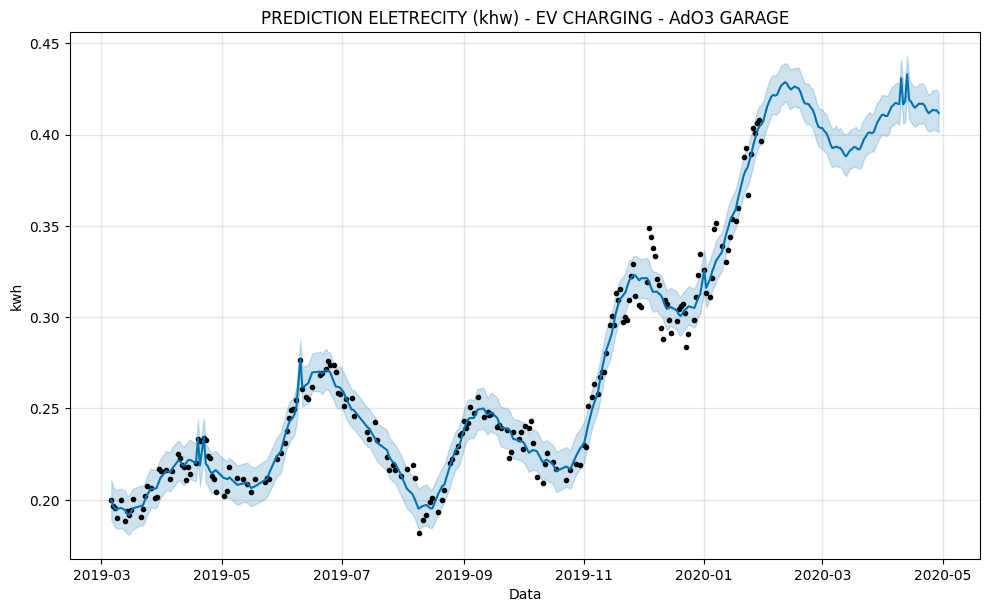

21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing


data shape: (342, 2)


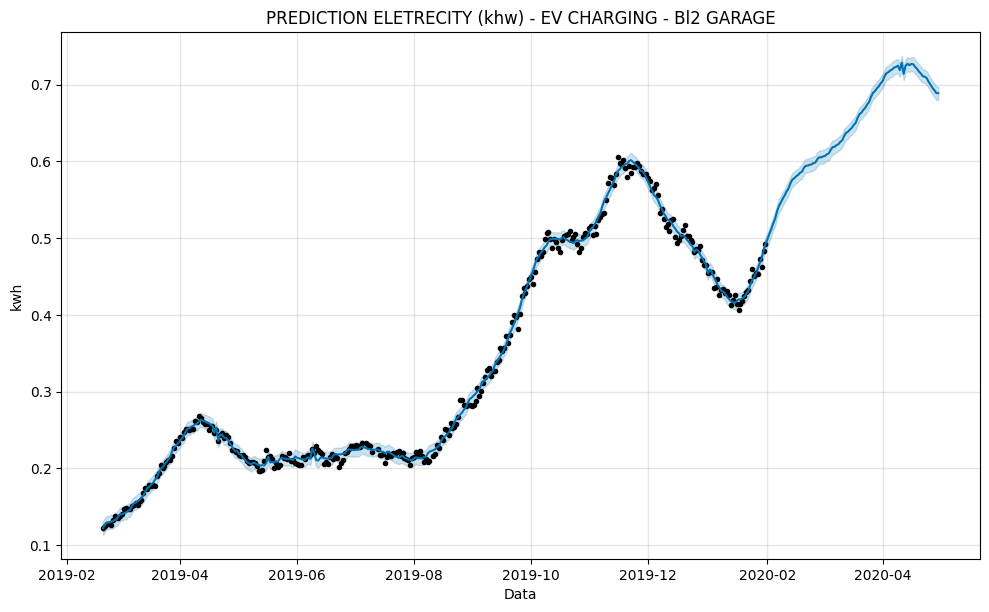

21:55:23 - cmdstanpy - INFO - Chain [1] start processing
21:55:23 - cmdstanpy - INFO - Chain [1] done processing


data shape: (281, 2)


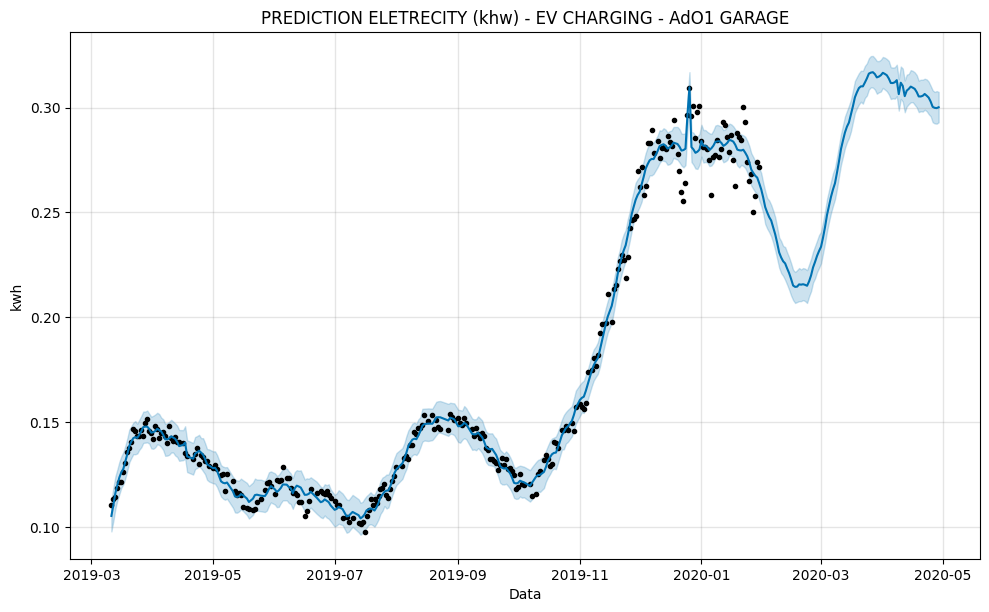

21:55:24 - cmdstanpy - INFO - Chain [1] start processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing


data shape: (240, 2)


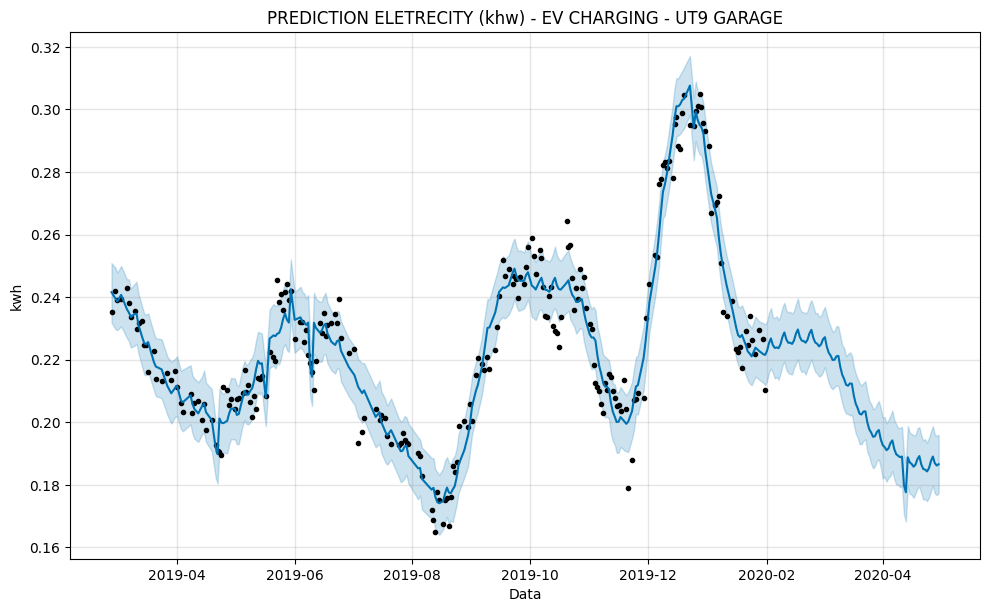

21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] done processing


data shape: (296, 2)


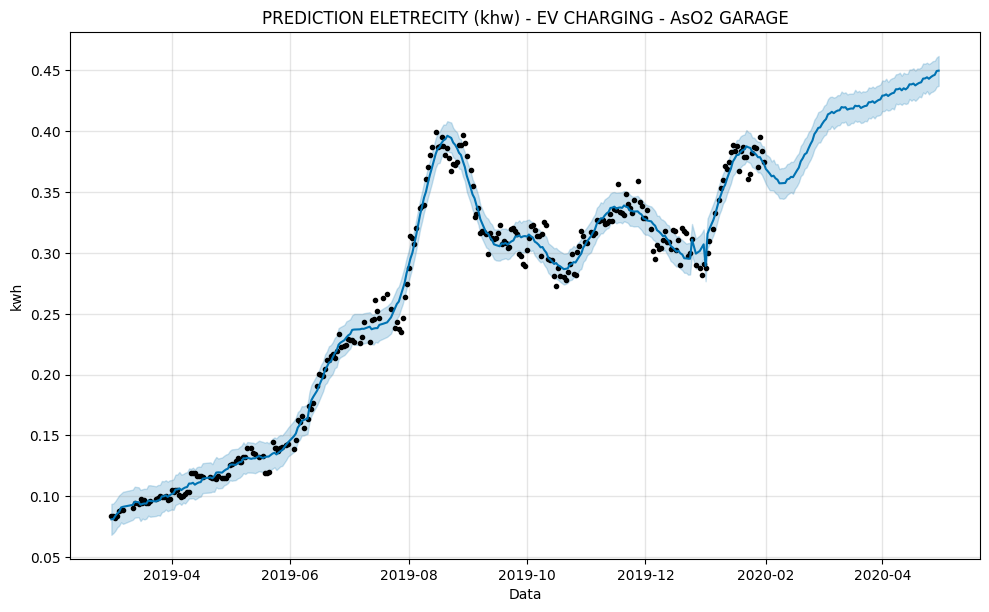

data shape: (0, 2)


ValueError: Dataframe has less than 2 non-NaN rows.

In [16]:
for id in time_series_df.keys():
    prophet_ts(time_series_df[id])

#### Since we are calculating a 30 day moving average to smooth out the data and therefore get more accurate predictions, some of the garages that do not have more than 30 days of data points will be populated with NaNs only. This is why we are getting the error above.

### ======================= TimeSeries - AUTOARIMA =======================

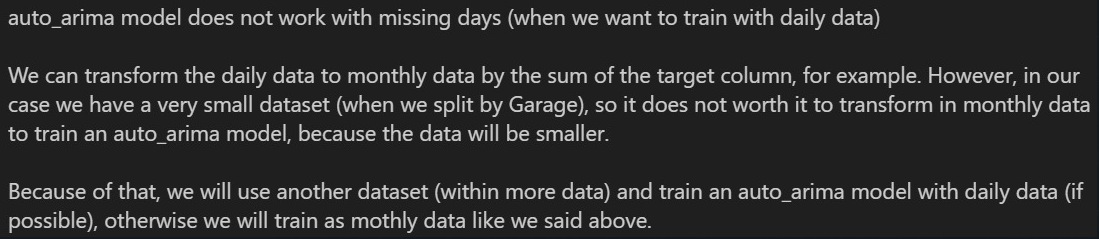